In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib


# import your reusable cleaning + preprocessing modules
import sys
sys.path.append("../src")

from data_cleaning import clean_dataset
from data_preprocessing import build_preprocessor

# Load raw dataset
df = pd.read_csv("../app/data/generated_diet_data.csv")

# Apply your cleaning pipeline
df = clean_dataset(df)

df.head()


✅ Saved to: ../app/data/generated_diet_data.csv

Class distribution (recommended_diet):

recommended_diet
Balanced Diet         1611
Low-Carb Diet          514
Heart-Healthy Diet     232
Iron-Rich Diet          72
High-Protein Diet       71
Name: count, dtype: int64


,age,gender,height_cm,weight_kg,bmi,activity_level,goal,medical_condition,diet_preference,water_intake_liters,sleep_hours,hemoglobin,sugar_level,cholesterol_level,recommended_diet
0,36,Male,177.6,69.9,34.6,Light,Lose Weight,Unknown,Non-Veg,1.70,7.5,15.5,Slightly High,Borderline,Low-Carb Diet
1,30,Male,180.7,81.3,24.9,Light,Lose Weight,Unknown,Veg,2.84,6.2,14.0,Normal,Borderline,Balanced Diet
2,38,Male,170.3,83.2,28.7,Light,Gain Muscle,Unknown,Veg,2.21,5.6,14.7,Normal,Borderline,Balanced Diet
3,47,Male,168.1,71.8,25.4,Sedentary,Lose Weight,Unknown,Veg,2.22,7.6,14.2,Slightly High,High,Heart-Healthy Diet
4,29,Male,164.3,71.3,26.4,Light,Lose Weight,Unknown,Non-Veg,1.48,7.2,14.1,Normal,Borderline,Balanced Diet


In [2]:
X = df.drop("recommended_diet", axis=1) 
y = df["recommended_diet"]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2000, 14), (500, 14), (2000,), (500,))

In [4]:
print(X_train.columns.tolist())



['age', 'gender', 'height_cm', 'weight_kg', 'bmi', 'activity_level', 'goal', 'medical_condition', 'diet_preference', 'water_intake_liters', 'sleep_hours', 'hemoglobin', 'sugar_level', 'cholesterol_level']


In [5]:
print(y_train)

2489        Balanced Diet
1170        Balanced Diet
798         Low-Carb Diet
1143        Balanced Diet
1462        Balanced Diet
              ...        
2064        Low-Carb Diet
272         Balanced Diet
308         Balanced Diet
1002    High-Protein Diet
1378        Balanced Diet
Name: recommended_diet, Length: 2000, dtype: object


In [6]:
preprocessor, num_cols, cat_cols = build_preprocessor(X_train)



In [7]:
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    ))
])


In [8]:
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
set(cat_cols + num_cols) - set(X_train.columns)


set()

In [10]:
y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.978

Classification Report:
                     precision    recall  f1-score   support

     Balanced Diet       0.98      1.00      0.99       322
Heart-Healthy Diet       0.98      1.00      0.99        47
 High-Protein Diet       1.00      0.50      0.67        14
    Iron-Rich Diet       1.00      0.71      0.83        14
     Low-Carb Diet       0.97      1.00      0.99       103

          accuracy                           0.98       500
         macro avg       0.99      0.84      0.89       500
      weighted avg       0.98      0.98      0.98       500


Confusion Matrix:
 [[322   0   0   0   0]
 [  0  47   0   0   0]
 [  7   0   7   0   0]
 [  0   1   0  10   3]
 [  0   0   0   0 103]]


In [11]:
# import os
# os.makedirs("../app/models", exist_ok=True)
# joblib.dump(model_pipeline, "../app/models/RandomForestClassifier.pkl")


Lets create a function for important measures!

In [12]:
def evaluate_model(pipeline, X_test, y_test, target_names=None):
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f}  |  Macro F1: {macro_f1:.4f}\n")
    print("Classification report:\n")
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    print("Confusion matrix:\n")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    return y_pred, cm




In [13]:
target_names=model_pipeline.named_steps['model'].classes_
print(target_names)

['Balanced Diet' 'Heart-Healthy Diet' 'High-Protein Diet' 'Iron-Rich Diet'
 'Low-Carb Diet']


In [14]:
# Evaluate baseline (already trained)
evaluate_model(model_pipeline, X_test, y_test, target_names=model_pipeline.named_steps['model'].classes_)


Accuracy: 0.9780  |  Macro F1: 0.8929

Classification report:

                    precision    recall  f1-score   support

     Balanced Diet       0.98      1.00      0.99       322
Heart-Healthy Diet       0.98      1.00      0.99        47
 High-Protein Diet       1.00      0.50      0.67        14
    Iron-Rich Diet       1.00      0.71      0.83        14
     Low-Carb Diet       0.97      1.00      0.99       103

          accuracy                           0.98       500
         macro avg       0.99      0.84      0.89       500
      weighted avg       0.98      0.98      0.98       500

Confusion matrix:

[[322   0   0   0   0]
 [  0  47   0   0   0]
 [  7   0   7   0   0]
 [  0   1   0  10   3]
 [  0   0   0   0 103]]


(array(['Iron-Rich Diet', 'Balanced Diet', 'Heart-Healthy Diet',
        'Balanced Diet', 'Balanced Diet', 'Low-Carb Diet',
        'Heart-Healthy Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Iron-Rich Diet',
        'Balanced Diet', 'Balanced Diet', 'Low-Carb Diet', 'Low-Carb Diet',
        'Balanced Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Heart-Healthy Diet', 'Balanced Diet',
        'Balanced Diet', 'Balanced Diet', 'Heart-Healthy Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Low-Carb Diet',
        'Heart-Healthy Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Heart-Healthy Diet', 'Balanced Diet'

Now it's time to weight the classes

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf_w = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
                n_estimators=300,
                class_weight="balanced",
                random_state=42
    ))
])

#train
rf_w.fit(X_train, y_train)

#evaluate
evaluate_model(rf_w, X_test, y_test, target_names=rf_w.named_steps['model'].classes_)

Accuracy: 0.9940  |  Macro F1: 0.9826

Classification report:

                    precision    recall  f1-score   support

     Balanced Diet       0.99      1.00      1.00       322
Heart-Healthy Diet       1.00      1.00      1.00        47
 High-Protein Diet       1.00      0.93      0.96        14
    Iron-Rich Diet       1.00      0.93      0.96        14
     Low-Carb Diet       0.99      0.99      0.99       103

          accuracy                           0.99       500
         macro avg       1.00      0.97      0.98       500
      weighted avg       0.99      0.99      0.99       500

Confusion matrix:

[[322   0   0   0   0]
 [  0  47   0   0   0]
 [  1   0  13   0   0]
 [  0   0   0  13   1]
 [  1   0   0   0 102]]


(array(['Iron-Rich Diet', 'Balanced Diet', 'Heart-Healthy Diet',
        'Balanced Diet', 'Balanced Diet', 'Low-Carb Diet',
        'Heart-Healthy Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Iron-Rich Diet',
        'Balanced Diet', 'Balanced Diet', 'Low-Carb Diet', 'Low-Carb Diet',
        'Balanced Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Heart-Healthy Diet', 'Balanced Diet',
        'Balanced Diet', 'Balanced Diet', 'Heart-Healthy Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Low-Carb Diet',
        'Heart-Healthy Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Heart-Healthy Diet', 'Balanced Diet'

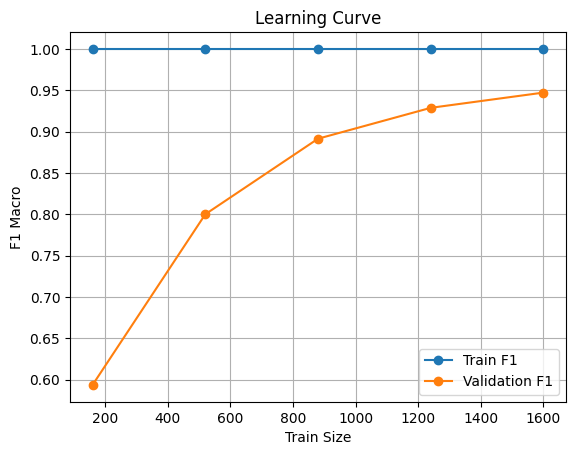

In [16]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    rf_w,
    X_train,
    y_train,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, marker='o', label='Train F1')
plt.plot(train_sizes, test_mean, marker='o', label='Validation F1')
plt.xlabel('Train Size')
plt.ylabel('F1 Macro')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_w, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print("RF with class_weight 5-fold macro-F1: ", scores.mean(), scores)

RF with class_weight 5-fold macro-F1:  0.9503286186630555 [0.94403566 0.89478254 0.9656556  0.98930515 0.95786414]


In [18]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
        "model__n_estimators" : [100, 200, 400],
        "model__max_depth" : [None, 10, 20, 40],
        "model__min_samples_leaf" : [1,2,4]
}

rs = RandomizedSearchCV(rf_w, param_dist, n_iter=10, scoring='f1_macro', cv = cv, n_jobs = -1, random_state=42)
rs.fit(X_train, y_train)
print("Best Score:", rs.best_score_)
best_pipeline = rs.best_estimator_

evaluate_model(best_pipeline, X_test, y_test)

Best Score: 0.9766797635319125
Accuracy: 0.9940  |  Macro F1: 0.9891

Classification report:

                    precision    recall  f1-score   support

     Balanced Diet       1.00      0.99      1.00       322
Heart-Healthy Diet       1.00      1.00      1.00        47
 High-Protein Diet       1.00      1.00      1.00        14
    Iron-Rich Diet       1.00      0.93      0.96        14
     Low-Carb Diet       0.97      1.00      0.99       103

          accuracy                           0.99       500
         macro avg       0.99      0.98      0.99       500
      weighted avg       0.99      0.99      0.99       500

Confusion matrix:

[[320   0   0   0   2]
 [  0  47   0   0   0]
 [  0   0  14   0   0]
 [  0   0   0  13   1]
 [  0   0   0   0 103]]


(array(['Iron-Rich Diet', 'Balanced Diet', 'Heart-Healthy Diet',
        'Balanced Diet', 'Balanced Diet', 'Low-Carb Diet',
        'Heart-Healthy Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Iron-Rich Diet',
        'Balanced Diet', 'Balanced Diet', 'Low-Carb Diet', 'Low-Carb Diet',
        'Balanced Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Heart-Healthy Diet', 'Balanced Diet',
        'Balanced Diet', 'Balanced Diet', 'Heart-Healthy Diet',
        'Balanced Diet', 'Low-Carb Diet', 'Low-Carb Diet',
        'Heart-Healthy Diet', 'Balanced Diet', 'Balanced Diet',
        'Low-Carb Diet', 'Balanced Diet', 'Balanced Diet', 'Balanced Diet',
        'Heart-Healthy Diet', 'Balanced Diet'

In [19]:
import joblib
joblib.dump(best_pipeline, "../app/RandomizedSearchCV.pkl")

['../app/RandomizedSearchCV.pkl']